# Project - Face Mask Prediction using U-Net

### Submitted by - Abhik Kar

##### Dated - 13-Sept-2020

##### Description:

Using transfer learning on an already trained model, objective is to predict the mask around the face in a given image using MobileNet model which is already trained to detect the face attributes. 

Only will train the last 6-7 layers and freeze the remaining layers to train the model for predicting the mask on the face. To be able to train the MobileNet model using the WIDER FACE dataset for various images with a single face and multiple faces.

##### Objective:
The objective of the project is to build a deep learning model using U-Net as architecture that will learn the pixel mapping of the face in an image.

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#### Mounting Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Loading the "images.npy" file

In [4]:
import os
os.chdir('/content/drive/My Drive/Deep Learning/Data Set/Segmentation')
path = '.'

In [5]:
ls

image.jpg      model-0.34.h5  model-0.40.h5  model-0.49.h5  model-0.65.h5
images.npy     model-0.35.h5  model-0.41.h5  model-0.50.h5  model-0.75.h5
mask.jpg       model-0.36.h5  model-0.42.h5  model-0.51.h5  model-0.94.h5
model-0.31.h5  model-0.37.h5  model-0.44.h5  model-0.54.h5  model-1.46.h5
model-0.32.h5  model-0.38.h5  model-0.46.h5  model-0.55.h5
model-0.33.h5  model-0.39.h5  model-0.47.h5  model-0.60.h5


In [6]:
pwd

'/content/drive/My Drive/Deep Learning/Data Set/Segmentation'

In [7]:
import numpy as np

In [8]:
data = np.load('/content/drive/My Drive/Deep Learning/Data Set/Segmentation/images.npy', allow_pickle='False')

#### Checking sample data from the loaded "images.npy" file

In [9]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

In [10]:
data[100][1]

[{'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.26327193932827736, 'y': 0.18497109826589594},
   {'x': 0.3206933911159263, 'y': 0.28516377649325625}]},
 {'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4257854821235103, 'y': 0.23121387283236994},
   {'x': 0.49837486457204766, 'y': 0.34104046242774566}]},
 {'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6197183098591549, 'y': 0.29865125240847784},
   {'x': 0.6988082340195017, 'y': 0.4624277456647399}]}]

#### Setting the necessary parameters including image dimensions

In [11]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

#### Create features and labels
* Here feature is the image
* The label is the mask
* Images stored in "X" array
* Masks  stored in "masks" array


In [12]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]),  HEIGHT_CELLS,WIDTH_CELLS))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 28)
        x2 = int(i["points"][1]['x'] * 28)
        y1 = int(i["points"][0]['y'] * 28)
        y2 = int(i["points"][1]['y'] * 28)
        masks[index][y1:y2, x1:x2] = 1

In [13]:
#Check the data
print(X_train.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.17647058 -0.00392157  0.16078436]
  [-0.11372548  0.082353    0.23921573]
  [-0.09019607  0.11372554  0.25490201]
  ...
  [ 0.05882359  0.13725495  0.30980396]
  [-0.02745098  0.03529418  0.20000005]
  [-0.04313725  0.0196079   0.18431377]]

 [[-0.05098039  0.12156868  0.28627455]
  [-0.09803921  0.09803927  0.26274514]
  [-0.04313725  0.16078436  0.29411769]
  ...
  [ 0.01176476  0.09803927  0.27058828]
  [-0.01176471  0.06666672  0.22352946]
  [-0.03529412  0.02745104  0.19215691]]

 [[-0.06666666  0.13725495  0.27058828]
  [-0.00392157  0.20000005  0.33333337]
  [ 0.04313731  0.24705887  0.38039219]
  ...
  [ 0.02745104  0.11372554  0.27058828]
  [-0.01960784  0.06666672  0.22352946]
  [ 0.00392163  0.06666672  0.21568632]]

 ...

 [[-0.78823531 -0.87450981 -0.81960785]
  [-0.90588236 -1.         -1.        ]
  [-0.63137257 -0.78823531 -0.78823531]
  ...
  [-0.50588238 -0.74117649 -0.66274512]
  [-0.49803919 -0.74901962 -0.66274512]
  [-0.51372552 -0.77254903 -0.7019608 ]]

 [

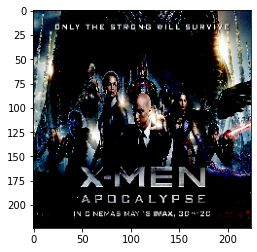

In [14]:
#Check the images
import matplotlib.pyplot as plt
print(X_train[408])
plt.imshow(X_train[408])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

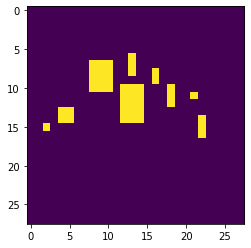

In [15]:
#Check the image mask
import matplotlib.pyplot as plt
print(masks[408])
plt.imshow(masks[408])

### Splitting the data into training and testing

In [16]:
X_test = X_train[400:]
y_test = masks[400:]

In [17]:
X_train = X_train[:-9]
y_train = masks[:-9]

#### Printing sample training image, image array and its mask

In [18]:
#Check the data
print(X_train.shape)
print(y_train.shape)

(400, 224, 224, 3)
(400, 28, 28)


In [19]:
#Check the data
print(X_test.shape)
print(y_test.shape)

(9, 224, 224, 3)
(9, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


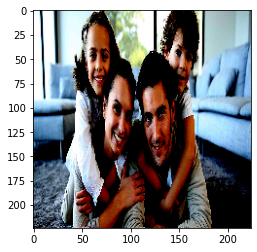

In [20]:
plt.imshow(X_train[13])

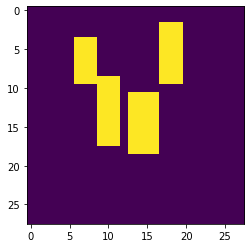

In [21]:
plt.imshow(y_train[13])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


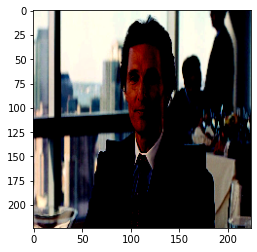

In [22]:
plt.imshow(X_test[3])

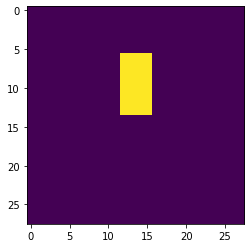

In [23]:
plt.imshow(y_test[3])

#### Creating Model - Training the last 7 layers and freeze the remaining layers to train the model for predicting the mask on the face

- Adding MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"

- Adding UNET architecture layers

In [24]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers[:-7]:
        layer.trainable = False

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

#### Dice coefficient

In [25]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

#### Define loss function

In [26]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

#### Create the model and print summary

In [27]:
model = create_model(False)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

#### Compile Model
* Define optimizer
* Define metrics
* Define loss

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

#### Define checkpoint and earlystopping

In [29]:
EPOCHS = 100 # Number of epochs
BATCH_SIZE = 1 
PATIENCE = 5 # Patience for early stopping
VERBOSE = 2

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

#### Fit the model
Fit the model using below parameters:
* epochs: 10
* batch_size: 1
* callbacks: checkpoint, reduce_lr, stop

In [31]:
model.fit(X_train, y_train, epochs=EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/100

Epoch 00001: loss improved from inf to 1.34168, saving model to model-1.34.h5
400/400 - 2s - loss: 1.3417 - dice_coefficient: 0.4349
Epoch 2/100

Epoch 00002: loss improved from 1.34168 to 0.86497, saving model to model-0.86.h5
400/400 - 2s - loss: 0.8650 - dice_coefficient: 0.5789
Epoch 3/100

Epoch 00003: loss improved from 0.86497 to 0.70574, saving model to model-0.71.h5
400/400 - 2s - loss: 0.7057 - dice_coefficient: 0.6343
Epoch 4/100

Epoch 00004: loss improved from 0.70574 to 0.62450, saving model to model-0.62.h5
400/400 - 2s - loss: 0.6245 - dice_coefficient: 0.6690
Epoch 5/100

Epoch 00005: loss improved from 0.62450 to 0.56777, saving model to model-0.57.h5
400/400 - 2s - loss: 0.5678 - dice_coefficient: 0.6934
Epoch 6/100

Epoch 00006: loss improved from 0.56777 to 0.54308, saving model to model-0.54.h5
400/400 - 2s - loss: 0.5431 - dice_coefficient: 0.7045
Epoch 7/100

Epoch 00007: loss improved from 0.54308 to 0.51692, saving model to model-0.52.h5
400/400 -

# Predicting Images using Testing Data Set

In [32]:
# Load previous model weight
WEIGHTS_FILE = "model-0.31.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_test, verbose = 1)

1/1 [==============================] - 0s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


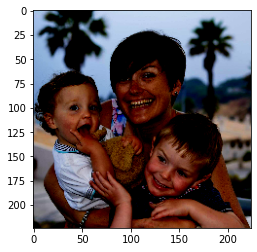

In [33]:
n = 0
plt.imshow(X_test[n])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


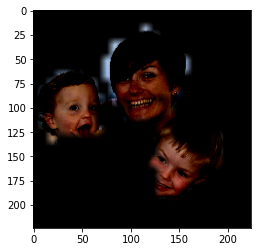

In [34]:
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

plt.imshow(out_image)

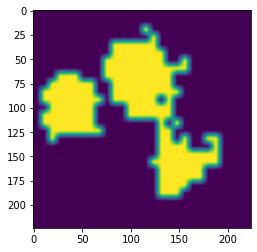

In [35]:
# Predicting the mask on the test image
plt.imshow(pred_mask, alpha = 1)

#### Impose the mask on the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


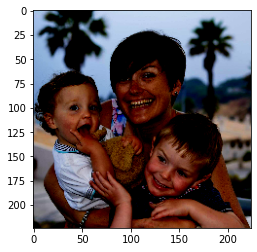

In [36]:
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

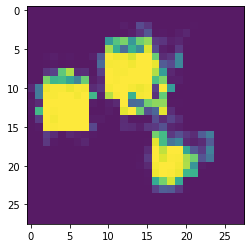

In [37]:
plt.imshow(y_pred[n], alpha = 0.9)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

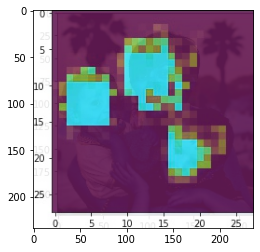

In [38]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
out_image = img
plt.imshow(out_image)
plt.imshow(mask, alpha=0.9)

# Conclusion

* Post evaluation of the test images this is pretty evident that using U-Net architecture our model has learnt pretty well the pixel mapping of the face in an image. We are able to able to train the model as backbone MobileNet model and thus using the WIDER FACE dataset for various images with a single face and multiple faces we are able to mask with minimum loss.


### Thank you